# TP 1: Parcours des protons dans la matière

### Par Mathieu Marquis, Charles-Antoine Parent et Thomas Piuze

In [30]:
import timeit
import numpy as np
import scipy as sp
import pandas as pd
import graphinglib as gl

from typing import Callable
from scipy.constants import N_A, c
from scipy.stats import moyal

## Questions:

### 1- Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

La contribution à la densité électronique d'une molécule pour chaque élément $i$ est donnée par
$$n_e^{(i)}=\rho A^{(i)}\frac{N_e^{(i)}N_A}{M^{(i)}}$$
où
$\rho$ : masse volumique de la molécule,
$A^{(i)}$ : abondance massique de l'élément $i$,
$N_e^{(i)}$ : nombre d'électrons par atome de l'élément $i$,
$N_A$ : nombre d'Avogadro,
$M^{(i)}$ : masse molaire de l'élément $i$.

Ainsi, la densité électronique d'une molécule avec $N$ éléments distincts correspond à
$$n_e=\rho N_A\sum_{i=1}^N\frac{A^{(i)}N_e^{(i)}}{M^{(i)}}$$


La cellule suivante donne les numéros atomiques, la fraction massique et la masse molaire des éléments composant l'eau et l'os compact, de même que la masse volumique de ces deux substances. Elle fait ensuite appel à la fonction `densite_electronique` pour obtenir la densité électronique de l'eau et de l'os compact. La fonction `densite_electronique` reçoit en argument la composition chimique d'une matière et sa masse volumique en g/cm $^3$ et retourne sa densité électronique en électrons par cm $^3$. Les données du NIST ont été utilisées.

In [31]:
def densite_electronique(composition: np.ndarray, rho: float) -> float:
    """
    Retourne la densité électronique en électrons par centimètre cube.

    Paramètres
    ----------
    composition : np.array
        Array où chaque ligne représente le numéro atomique, la composition atomique du milieu
        (en fraction de 1) et la masse molaire de chaque élément composant le milieu.
    rho : float
        Densité du milieu en grammes par mole.
    """
    assert composition[:,1].sum() == 1, "l'abondance chimique de tous les éléments devrait être sommée à 1."
    return rho * N_A * np.sum(composition[:,1] * composition[:,0] / composition[:,2], axis=0)

# Numéros atomiques, composition atomique et masse molaire
composition_eau = np.array([
    [1, 0.111894, 1.008],
    [8, 0.888106, 15.999]
])
composition_os = np.array([
    [1, 0.063984, 1.008], 
    [6, 0.278000, 12.011], 
    [7, 0.027000, 14.007], 
    [8, 0.410016, 15.999],
    [12, 0.002000, 24.305], 
    [15, 0.070000, 30.974], 
    [16, 0.002000, 32.06], 
    [20, 0.147000, 40.078]
])

# Masses volumiques en g/cm^3
rho_eau = 1.00000
rho_os = 1.85000

# Densités électroniques en électrons/cm^3
n_eau = densite_electronique(composition_eau, rho_eau)
n_os = densite_electronique(composition_os, rho_os)
print("Densité électronique de l'eau :", n_eau)
print("Densité électronique le l'os compact :", n_os)

Densité électronique de l'eau : 3.342810286137214e+23
Densité électronique le l'os compact : 5.9058775990097234e+23


### 2- Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique ($T$). Pour expliciter la dépendance en $T$ de $S_{col}$, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation $I$ de ces matériaux sur le site du NIST également.

La cellule suivante définit d'abord quelques constantes importantes, de même que les énergies moyennes d'excitation de l'eau liquide et de l'os compact telles que précisées sur le site du NIST. Elle fait ensuite appel à la fonction `pouvoir_collisionnel` pour tracer les courbes du pouvoir d'arrêt collisionnel massique. La fonction `pouvoir_collisionnel` reçoit en argument l'énergie cinétique du proton (MeV), la densité électronique du milieu (électrons/cm $^3$), l'énergie moyenne d'excitation du milieu (MeV) et la masse volumique du milieu (g/cm $^3$). Elle retourne le pouvoir d'arrêt collisionnel massique si `massique is True`, et le pouvoir d'arrêt collisionnel standard sinon.

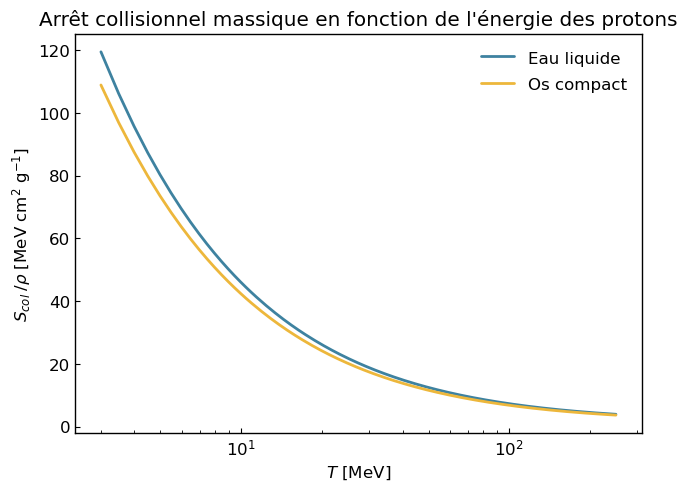

In [32]:
r_e = 10**2*sp.constants.value("classical electron radius") # En cm
m_e = sp.constants.value("electron mass energy equivalent in MeV") / c**2
m_p = sp.constants.value("proton mass energy equivalent in MeV") / c**2
I_eau = 75.000000e-6
I_os = 91.900000e-6

def calcul_S_col(T: float | np.ndarray, n_e: float, I: float, rho: float) -> float | np.ndarray:
    """
    Retourne le pouvoir d'arrêt collisionnel des protons.

    Paramètres
    ----------
    T : float | np.ndarray
        Énergie cinétique en MeV.
    n_e : float
        Densité électronique du matériau en électrons/cm^3.
    I : float
        Énergie moyenne d'excitation du matériau en MeV.
    rho : float
        Masse volumique en g/cm^3.
    """
    gamma = T / (m_p*c**2) + 1
    beta = np.sqrt((gamma**2 - 1) / gamma**2)
    T_e_max = (2*m_e*c**2 * (gamma**2 - 1)) / (1+(m_e/m_p)**2 + 2*m_e/m_p * gamma)
    S_col = 2*np.pi*r_e**2*m_e*c**2*n_e / beta**2 * (np.log(2*m_e*(c*beta*gamma)**2*T_e_max / I**2) - 2*beta**2)
    return S_col / rho

fig = gl.Figure(
    log_scale_x=True,
    x_label="$T$ [MeV]",
    y_label=r"$S_{col}\:/\rho$ [MeV cm$^2$ g$^{-1}$]",
    title="Arrêt collisionnel massique en fonction de l'énergie des protons"
)
fig.add_elements(gl.Curve.from_function(lambda T: calcul_S_col(T, n_eau, I_eau, rho_eau), 3, 250, label="Eau liquide"))
fig.add_elements(gl.Curve.from_function(lambda T: calcul_S_col(T, n_os, I_os, rho_os), 3, 250, label="Os compact"))
fig.show()


## Portée des protons dans la matière

### L’approximation d’une décélération continue (*Continuous Slowing Down Approximation*, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

### 3- En quoi la seule considération des interactions des protons avec les électrons du milieu est-elle justifiée ? Appuyez votre réponse en comparant les contributions des interactions nucléaires (protons avec noyaux atomiques du milieu) et radiatives (pertes d’énergie par *Bremsstrahlung*) au pouvoir d’arrêt total sur la plage 3-250 MeV. Les données PSTAR et un graphique pourraient être utiles.

Les graphiques suivants, construits à partir des données PSTAR, montrent qu'entre 3 et 250 MeV, la contribution des interactions nucléaires au pouvoir d'arrêt collisionnel est plusieurs ordres de grandeur en dessous de celle du Bremsstrahlung. De fait, la contribution du Bremsstrahlung épouse presque parfaitement le pouvoir d'arrêt total. Il est donc possible de négliger les interactions nucléaires pour des protons se situant dans cet intervalle d'énergie et de ne considérer que les interactions radiatives.

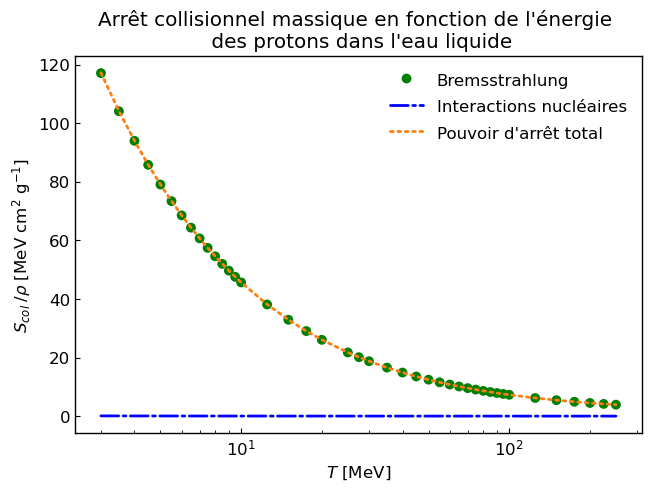

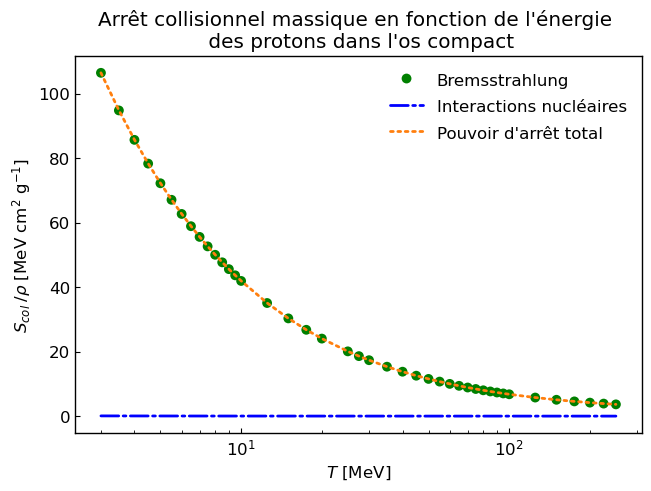

In [33]:
fichier_eau, fichier_os = 'devoirs/tp1/pstar_eau.csv', 'devoirs/tp1/pstar_os.csv'

def portee(file, title):
    donnees = pd.read_csv(file, sep=' ', index_col=False)
    energy = np.array(donnees['Kinetic'])
    bremss = np.array(donnees['Electron'])
    nuclear = np.array(donnees['Nuclear'])
    total = np.array(donnees['Total'])
    
    fig = gl.Figure(
        log_scale_x=True,
        x_label="$T$ [MeV]",
        y_label=r"$S_{col}\:/\rho$ [MeV cm$^2$ g$^{-1}$]",
        title=title
    )
    fig.add_elements(
        gl.Scatter(energy, bremss, face_color='g', label='Bremsstrahlung'),
        gl.Curve(energy, nuclear, color='b', line_style='-.', label='Interactions nucléaires'),
        gl.Curve(energy, total, color='tab:orange', line_style=':', label="Pouvoir d'arrêt total")
    )
    fig.show()
    
portee(fichier_eau, title="Arrêt collisionnel massique en fonction de l'énergie \n des protons dans l'eau liquide")
portee(fichier_os, title="Arrêt collisionnel massique en fonction de l'énergie \n des protons dans l'os compact")

La portée par CSDA ($R_{CSDA}$) est obtenue en intégrant l’inverse du pouvoir d’arrêt total par
rapport à l’énergie :

$$R_{CSDA} = \int_0^{T_i}\frac{dT'}{S_{col}},$$

### 4-  Pourquoi intègre-t-on l’inverse du pouvoir d’arrêt pour déterminer la portée ?

Le pouvoir d'arrêt collisionnel est défini comme:

$$ S_{col} = -\left(\frac{dT}{dx}\right)_{col} $$

Soit l'opposé de la variation d'énergie cinétique par unité de longueur. Ainsi, la portée peut être déterminée en intégrant l'élément de longueur $dx$ le long du parcours d'un proton :

$$\int_{x(T_i)}^{x(0)}dx = -\int_{x(0)}^{x(T_i)}dx = \int_0^{T_i}\frac{dT'}{-(dT'/dx)_{col}} = \int_0^{T_i}\frac{dT'}{S_{col}} =  R_{CSDA}$$

Ce qui correspond effectivement à la portée de la particule. L'intégration de l'inverse du pouvoir d'arrêt est donc due à la définition de $S_{col}$.

### 5- Justifiez la nécessité d’employer une méthode numérique pour calculer la portée des protons.

La portée des protons est obtenue en intégrant la fonction inverse du pouvoir d'arrêt collisionnel, soit
\begin{align*}
\frac1{S_{col}}&=\left[\frac{2\pi r_e^2m_ec^2n_e}{\beta^2}\left(\ln\left(\frac{2m_ec^2\beta^2\gamma^2T_e^{max}}{I^2}\right)-2\beta^2\right)\right]^{-1}\\
&=\left[U\left(\frac1{\beta^2}\ln\left(\frac{a\beta^2\gamma^2T_e^{max}}{I^2}\right)-2\right)\right]^{-1}
\end{align*}
Avec les équivalences connues, la dépendance en $T$ de cette expression peut être explicitée telle que
\begin{align*}
\frac1{S_{col}}&=\left[U\left(\frac{1}{1-\gamma^{-2}}\ln\left(\frac{a(\gamma^2-1)\frac{a(\gamma^2-1)}{b+\delta\gamma}}{I^2}\right)-2\right)\right]^{-1}\\
&=\left[U\left(\frac{1}{1-\gamma^{-2}}\ln\left(k\frac{(\gamma^2-1)^2}{b+\delta\gamma}\right)-2\right)\right]^{-1}\\
&=\left[U\left(\frac{1}{1-\left(\frac T{m_pc^2}+1\right)^{-2}}\ln\left(k\frac{\left(\left(\frac T{m_pc^2}+1\right)^2-1\right)^2}{b+\delta\left(\frac T{m_pc^2}+1\right)}\right)-2\right)\right]^{-1}\\
\end{align*}
Pour calculer la portée, il faut intégrer cette expression par rapport à $T$. Selon le principe « Dérive qui veut, intègre qui peut. », nous pouvons constater que l'intégration de cette expression analytiquement serait un défi... intéressant. L'intégration numérique est donc essentielle.

### 6- Implémenter deux algorithmes d’intégration numérique pour calculer la portée des protons dans l’eau et dans l’os compact ; le premier avec la méthode des trapèzes et le second avec la méthode de Romberg. Considérez des protons d’énergie initiale de 150 MeV à l’entrée du milieu. Estimez le nombre de tranches requises pour atteindre la précision machine avec chaque méthode, et discutez des conséquences sur le temps de calcul. Notez que comme l’expression 4 n’est valide que pour des protons ayant une énergie supérieure à 3 MeV, cette valeur sera utilisée comme borne d’intégration au lieu de 0. Le biais introduit dans les résultats par cette approximation ne vous sera pas reproché.

La cellule suivante définit les fonctions qui seront intégrées par les deux méthodes demandées. Les fonctions `f_eau` et `f_os` ne sont fonction que de l'énergie cinétique $T$ ce qui facilite leur utilisation.

In [34]:
def inverse_S_col(T: float | np.ndarray, n_e: float, I: float) -> float | np.ndarray:
    gamma = T / (m_p*c**2) + 1
    beta = np.sqrt((gamma**2 - 1) / gamma**2)
    T_e_max = (2*m_e*c**2 * (gamma**2 - 1)) / (1+(m_e/m_p)**2 + 2*m_e/m_p * gamma)
    S_col = 2*np.pi*r_e**2*m_e*c**2*n_e / beta**2 * (np.log(2*m_e*(c*beta*gamma)**2*T_e_max / I**2) - 2*beta**2)
    return 1 / S_col

f_eau = lambda T: inverse_S_col(T, n_eau, I_eau)
f_os = lambda T: inverse_S_col(T, n_os, I_os)

La fonction `evaluer_avec_trapezes` permet de faire l'évaluation d'une fonction avec un nombre $N$ de trapèzes entre les bornes $a$ et $b$. Cette fonction est appelée à répétition par la fonction `methode_des_trapezes`, qui optimise le nombre de tranches pour obtenir une erreur en-dessous du seuil établi.

In [35]:
def evaluer_avec_trapezes(
        func: Callable,
        a: float,
        b: float,
        N: int,
) -> float:
    h = (b-a) / N
    y = func(np.linspace(a, b, N+1))
    return h * (0.5*(y[0] + y[-1]) + y[1:-1].sum())

def methode_des_trapezes(
        func: Callable,
        a: float,
        b: float,
        n0: int=10,
        erreur_max: float=1e-14,
        n_max: int=np.inf,
        precision_machine: bool=False
) -> tuple[float, float, int]:
    """
    Cette fonction calcule une intégrale numérique de la fonction fournie sur l'intervalle [a, b]
    en utilisant la méthode des trapèzes. Elle s'arrête lorsque l'erreur d'approximation est inférieure
    à la valeur spécifiée par 'erreur_max' ou lorsque le nombre maximum de tranches est atteint.

    Paramètres
    ----------
    func : Callable
        La fonction à intégrer.
    a : float
        Borne inférieure de l'intervalle d'intégration.
    b : float
        Borne supérieure de l'intervalle d'intégration.
    n0 : int
        Nombre initial de tranches. Par défaut, c'est 10.
    erreur_max : float
        Erreur d'approximation maximale tolérée. Par défaut, c'est 1e-14.
    n_max : int 
        Nombre maximum de tranches. Par défaut, il n'y a pas de limite.
    precision_machine : bool
        Spécifie si la précision machine est recherchée. Si oui, l'erreur maximale est remplacée par 1e-16 * la valeur
        de l'intégrale calculée à chaque itération. Par défaut, c'est False.

    Retourne
    --------
    tuple[float, float, int]: La valeur de l'intégrale approximée, l'erreur d'approximation, et le nombre de tranches
    utilisées.
    """
    n = n0
    h = (b-a) / n

    I_last = evaluer_avec_trapezes(func, a, b, n)

    erreur = np.inf
    if precision_machine:
        condition = lambda err, I: err > 1e-16 * I
    else:
        condition = lambda err, *args: err > erreur_max
    while condition(erreur, I_last) and n < n_max:
        n *= 2
        h /= 2
        I_new = 0.5 * I_last + h * func(np.linspace(a+h, b-h, n//2)).sum()
        erreur = np.abs(I_new - I_last) / 3
        I_last = I_new

    return I_last, erreur, n

print(methode_des_trapezes(f_eau, 3, 150, precision_machine=False))
print(methode_des_trapezes(f_os, 3, 150, precision_machine=False))

(15.752818650610243, 8.881784197001252e-15, 20971520)
(9.159420322790426, 2.960594732333751e-15, 20971520)


La fonction `methode_de_romberg` utilise également la fonction `evaluer_avec_trapezes` pour calculer l'intégrale avec une autre méthode.

In [ ]:
def methode_de_romberg(
        func: Callable,
        a: float,
        b: float,
        n0: int=10,
        erreur_max: float=1e-14,
        n_max: int=np.inf,
        precision_machine: bool=False
) -> tuple[float, float, int]:
    """
    Calcule l'intégrale d'une fonction quelconque par la méthode de Romberg.

    Paramètres
    ----------
    func : Callable
        Fonction à intégrer.
    a : float
        Borne d'intégration inférieure.
    b : float
        Borne d'intégration suppérieure.
    n0 : int
        Nombre de tranches utilisés pour la première itération.
    erreur_max : float
        Erreur d'approximation maximale tolérée. Par défaut, c'est 1e-14.
    n_max : int
        Nombre maximum de tranches pour arrêter la récursion.
    precision_machine : bool
        Spécifie si la précision machine est recherchée. Si oui, l'erreur maximale est remplacée par 1e-16 * la valeur
        de l'intégrale calculée à chaque itération. Par défaut, c'est False.

    Retourne
    --------
    tuple[float, float, int]: La valeur de l'intégrale approximée, l'erreur d'approximation, et le nombre de tranches
    utilisées.
    """
    n = n0

    R = [[evaluer_avec_trapezes(func, a, b, n)]]
    
    i = 0
    erreur = np.inf
    if precision_machine:
        condition = lambda err, I: err > 1e-16 * I
    else:
        condition = lambda err, *args: err > erreur_max
    while condition(erreur, R[-1][-1]) and n < n_max:
        print(n, erreur)
        i += 1
        n *= 2
        R_i = [evaluer_avec_trapezes(func, a, b, n)]

        for m in range(1, i+1):
            R_i.append(1/(4**m - 1) * (4**m * R_i[m-1] - R[i-1][m-1]))

        erreur = 1/(4**m - 1) * np.abs(R_i[-1] - R[-1][-1])
        R.append(R_i)
    return R[-1][-1], erreur, n

print(methode_de_romberg(f_eau, 3, 150, precision_machine=True))
print(methode_de_romberg(f_os, 3, 150, precision_machine=True))

10 inf
20 0.0073408635415000605
40 1.5624428358525695e-05
80 2.0547937689271415e-07
160 2.1712606161818436e-09
320 1.270228497165574e-11
640 3.446045511081692e-14
(15.75281865061023, 3.8816806964859284e-17, 1280)
10 inf
20 0.004320884502352721
40 9.349382069837968e-06
80 1.2268648499946447e-07
160 1.2882480372216413e-09
320 7.454270501610612e-12
640 1.988348435838566e-14
(9.159420322790428, 2.1360086514182344e-17, 1280)


### 7- Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.


Le code suivant utilise les fonctions `methode_des_trapezes` et `methode_de_romberg` pour calculer les portées et les erreurs associées en fonction du nombre de tranches considéré. Le nombre de tranches est doublé entre chaque évaluation. La figure produite présente une échelle verticale standard pour la portée et une échelle verticale logarithmique pour l'erreur d'approximation. L'échelle horizontale représentant le nombre de tranches est elle aussi logarithmique. Les courbes en pointillé représentent l'erreur d'approximation, tandis que les courbes en trait plein représentent la portée calculée.

1 inf
1 inf
2 1.5662956886376325
1 inf
2 1.5662956886376325
4 0.06097396745498607
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
32 0.0002423539161799937
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
32 0.0002423539161799937
64 2.378899527677447e-05
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
32 0.0002423539161799937
64 2.378899527677447e-05
128 1.411888755242785e-06
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
32 0.0002423539161799937
64 2.378899527677447e-05
128 1.411888755242785e-06
256 4.40942073964834e-08
1 inf
2 1.5662956886376325
4 0.06097396745498607
8 0.010005393273894825
16 0.0017255497196178027
32 0.0002423

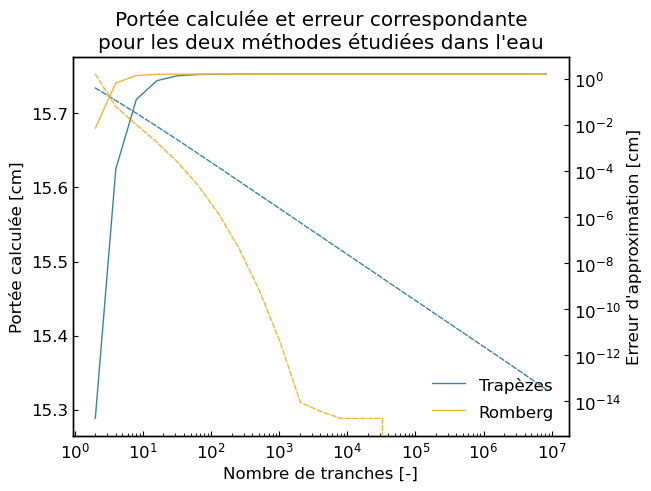

In [37]:
fig = gl.Figure(
    x_label="Nombre de tranches [-]",
    y_label="Portée calculée [cm]",
    log_scale_x=True,
    title="Portée calculée et erreur correspondante\npour les deux méthodes étudiées dans l'eau"
)
axe_erreur = fig.create_twin_axis(is_y=True, label="Erreur d'approximation [cm]", log_scale=True)
valeurs_max_n = np.logspace(0, 23, 24, base=2)[1:]
donnees_trapezes = np.array(
    [[n_max, *methode_des_trapezes(f_eau, 3, 150, n0=1, n_max=n_max, erreur_max=0)[:2]] for n_max in valeurs_max_n]
)
donnees_romberg = np.array(
    [[n_max, *methode_de_romberg(f_eau, 3, 150, n0=1, n_max=n_max, erreur_max=0)[:2]] for n_max in valeurs_max_n]
)

fig.add_elements(
    gl.Curve(donnees_trapezes[:,0], donnees_trapezes[:,1], label="Trapèzes", line_width=1),
    gl.Curve(donnees_romberg[:,0], donnees_romberg[:,1], label="Romberg", line_width=1),
)
axe_erreur.add_elements(
    gl.Curve(donnees_trapezes[:,0], donnees_trapezes[:,2], line_style="--", line_width=1),
    gl.Curve(donnees_romberg[:,0], donnees_romberg[:,2], line_style="--", line_width=1),
)
fig.show()

On remarque que l'erreur de la méthode de Romberg converge bien plus rapidement vers des faibles valeurs, et l'erreur devient très près de l'erreur machine.

## Estimation analytique de l'erreur

### Pour la méthode des trapèzes, obtenez la valeur de l’erreur sur la portée calculée à l’ordre le plus grand. À cette fin, il faut connaître la dérivée première de la fonction à intégrer (qui est l’inverse du pouvoir d’arrêt).

### 8- Établir l’expression analytique de la dérivée du pouvoir d’arrêt en fonction de $T$. Cette première étape vous permettra de calculer la dérivée de l’inverse du pouvoir d’arrêt plus facilement ensuite. Pour vous aider, vous pouvez exprimer le pouvoir d’arrêt en fonction de $\gamma$ et utiliser le théorème de dérivation des fonctions composées. Utilisez aussi les définitions suivantes pour simplifier la notation :

$$
\begin{align*}
T_e^{max} = \frac{a(\gamma^2-1)}{b+\delta\gamma}, \quad \text{avec} \quad a = 2m_ec^2, \quad b = 1+(\frac{m_e}{m_p})^2 \quad \text{et} \quad \delta = 2\frac{m_e}{m_p}
\end{align*}
$$

### et

$$
\begin{align*}
U &= 2\pi r_e^2m_ec^2n_e \\
k &= \frac{a^2}{I^2}
\end{align*}
$$

### sachant aussi que

$$
\begin{align*}
T = (\gamma-1)m_pc^2 \rightarrow \gamma = \frac{T}{m_pc^2}+1 \\
\gamma = \frac{1}{\sqrt{1-\beta^2}} \rightarrow \gamma^2\beta^2 = \gamma^2-1
\end{align*}
$$

La dérivée du pouvoir d'arrêt par rapport à $T$ se calcule comme suit: 

$$ \frac{dS_{col}}{dT} = \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} $$

Exprimons d'abord $S_{col}$ en fonction de $\gamma$ uniquement:

$$ 
\begin{align*}
    S_{col} &= 2\pi r_e^2m_ec^2n_e\frac{1}{\beta^2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2T_e^{max}}{I^2}\right)-2\beta^2\right] \\ 
    &= \frac{U}{\beta^2}\left[\ln\left(\frac{a\beta^2\gamma^2\cdot(\gamma^2-1)}{I^2(b+\delta\gamma)}\right)-2\beta^2\right] \\ 
    &= \frac{U\gamma^2}{\gamma^2-1}\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)-2U
\end{align*}
$$

On dérive ensuite $S_{col}$ par rapport à $\gamma$:

$$ 
\begin{align*}
    \frac{dS_{col}}{d\gamma} &= \left[\frac{2U\gamma}{\gamma^2-1}-\frac{2U\gamma^3}{(\gamma^2-1)^2}\right]\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)+\frac{U\gamma^2}{\gamma^2-1}\left[\frac{b+\delta\gamma}{k(\gamma^2-1)^2}\left(\frac{4k\gamma(\gamma^2-1)}{b+\delta\gamma}-\frac{k\delta(\gamma^2-1)^2}{(b+\delta\gamma)^2}\right)\right] \\
    &= -\frac{2U\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)+\frac{U\gamma^2}{(\gamma^2-1)^2}\left[4\gamma-\frac{\delta(\gamma^2-1)}{b+\delta\gamma}\right] \\
    &= \frac{U\gamma}{(\gamma^2-1)^2}\left[4\gamma^2-\frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}-2\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)\right] 
\end{align*}
$$

Pour $\frac{d\gamma}{dT}$, nous avons:

$$ \gamma = \frac{T}{m_pc^2}+1 \longrightarrow \frac{d\gamma}{dT} = \frac{1}{m_pc^2} $$

Donc:

$$ 
\begin{align*}
    \frac{dS_{col}}{dT} &= \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} \\
    &= \frac{U\gamma}{m_pc^2(\gamma^2-1)^2}\left[4\gamma^2-\frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}-2\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)\right] \\
    \text{où} \quad \gamma &= \gamma(T) = \frac{T}{m_pc^2}+1 
\end{align*}
$$

### 9- Rapportez vos portées calculées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapèzes) et évaluées de façon pratique (pour la méthode des trapèzes et de Romberg). Il s’agit essentiellement des résultats déjà obtenus (auxquels on ajoute les erreurs calculées pour la méthode des trapèzes). Commentez vos résultats.


Si on néglige les termes en $\mathcal{O}(h^4)$ et plus, l'erreur d'approximation $\epsilon$ de la méthode des trapèzes est

$$ \epsilon = \frac{1}{12}h^2[f'(a)-f'(b)] $$

et puisque la fonction à intégrer est $f(T) = \frac{1}{S_{col}(T)}$, $f'(T)$ devient :

$$ f'(T) = \frac{-1}{S_{col}^2(T)}\frac{dS_{col}}{dT} $$

La cellule suivante comporte la fonction `derivee` permettant de calculer la dérivée du pouvoir d'arrêt collisionnel par rapport à $T$. La fonction `erreur_trapezes` se sert ensuite de cette dérivée pour calculer l'erreur d'approximation.

In [38]:
def derivee(T, n_e, I):
    # Calcul des variables et constantes
    gamma = T / (m_p * c**2) + 1
    a = 2 * m_e * c**2
    b = 1 + (m_e / m_p)**2
    delta = 2 * m_e / m_p
    U = np.pi * r_e**2 * a * n_e
    k = a**2/I**2
    # 4 facteurs/termes pour la dérivée
    d1 = U * gamma / (m_p * c**2 * (gamma**2 - 1)**2)
    d2 = 4 * gamma**2
    d3 = delta * gamma * (gamma**2 - 1) / (b + delta * gamma)
    d4 = 2 * np.log(k * (gamma**2 - 1)**2 / (b + delta * gamma))
    return d1 * (d2 - d3 - d4)

def erreur_trapezes(a, b, N, func, n_e, I):
    h = (b - a) / N
    f_prime_a = - func(a)**2 * derivee(a, n_e, I)
    f_prime_b = - func(b)**2 * derivee(b, n_e, I)
    return h**2 / 12 * (f_prime_a - f_prime_b)

print(erreur_trapezes(3, 150, 20971520, f_eau, n_eau, I_eau))
print(erreur_trapezes(3, 150, 20971520, f_os, n_os, I_os))

5.347365288488503e-15
3.150673278877834e-15


Avec une erreur maximale de $10^{-14}$, les portées calculées et erreurs sont données au Tableau 1.

$$
\begin{aligned}
    & \text {Tableau 1. Portées calculées et erreurs d'approximation théoriques et numériques correspondantes}\\
    &\begin{array}{cccccc}
        \hline
        \text{Milieu} & \text{Portée calculée} & \text{Portée calculée} & \text{Erreur calculée} & \text{Erreur évaluée} & \text{Erreur évaluée} \\
        & \text{par trapèzes} & \text{par Romberg} & & \text{pour trapèzes} & \text{pour Romberg} \\
        \text{-} & \text{cm} & \text{cm} & 10^{-15}\ \text{cm} & 10^{-15}\ \text{cm} & 10^{-15}\ \text{cm} \\
        \hline
        \text{Eau} & 15.752818650610243 & 15.752818650610228 & 5.347 & 8.881784197001252 & 1.7763568394002505 \\
        \text{Os} & 9.159420322790425 & 9.159420322790428 & 3.151 & 2.960594732333751 & 1.7763568394002505 \\
        \hline
    \end{array}
\end{aligned}
$$

On remarque que les portées calculées sont égales jusqu'à les deux dernières décimales, illustrant le fait que les intégrales des deux méthodes convergent vers la même valeur. On voit aussi que l'ordre de grandeur des erreurs théoriques est comparable à celui des erreurs numériques, et même que l'erreur numérique est inférieure dans plusieurs cas.

## Optimisation

### Supposons maintenant que l’on cherche à réduire au maximum le temps de calcul, disons pour évaluer en temps quasi-réel la portée de chaque proton individuel émanant de l’accélérateur et dont on connaîtrait précisément l’énergie. Ces protons ont une distribution en énergie pouvant être approximée par une distribution de Moyal, que vous pourrez générer avec `scipy.stats.moyal` avec les paramètres `loc=150, scale=4` (unités en MeV).

### 10- . Utilisez ``moyal.rvs`` pour générer aléatoirement 10 000 énergies tirées de cette distribution et tracez-la (sous forme d’histogramme).

Le code suivant utilise ``moyal.rvs`` pour générer la distribution recherchée, qui est ensuite représentée sous forme d'histogramme divisé en 40 classes.

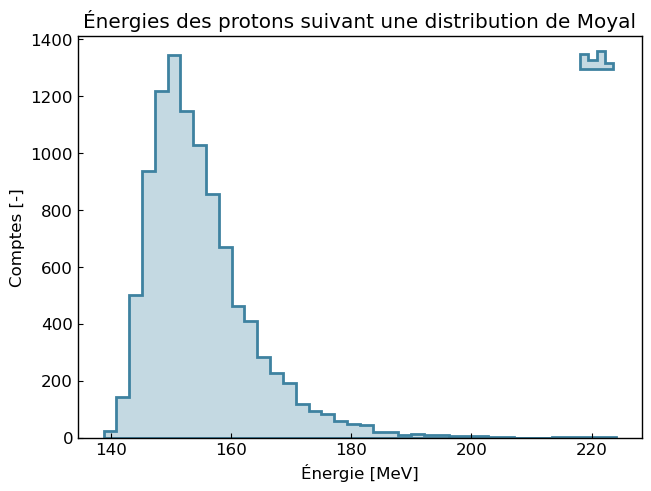

In [39]:
energy = moyal(loc=150, scale=4)
distribution = energy.rvs(size=10000)

fig = gl.Figure('Énergie [MeV]', 'Comptes [-]', title="Énergies des protons suivant une distribution de Moyal")
fig.add_elements(gl.Histogram(distribution, number_of_bins=40, show_params=False, label='', normalize=False))
fig.show()

### 11- À l’aide du module ``timeit``, estimez le nombre de protons que vous pouvez calculer par seconde selon trois méthodes : vos implémentations des méthodes par trapèzes et Romberg ainsi que la fonction ``scipy.integrate.quad``. Utilisez les 10 000 valeurs d’énergie générées plus haut pour faire vos tests. Afin de comparer des pommes avec des pommes, vos calculs doivent tous atteindre la précision par défaut de la routine ``scipy.integrate.quad``.

Les cellules suivantes se servent du module ``timeit`` et de la précision par défaut de $1.49\times10^{-8}$ de la routine ``scipy.integrate.quad`` pour déterminer le nombre de protons par seconde pouvant être calculé par chaque méthode dans l'os compact.

In [40]:
erreur_scipy = 1.49e-8
test = "for proton in distribution: sp.integrate.quad(f_os, 3, proton)"

time = timeit.timeit(test, globals=globals(), number=1)
print('scipy.integrate.quad :', len(distribution)/time, 'protons/s')

scipy.integrate.quad : 2279.1884092786845 protons/s


In [41]:
test = "for proton in distribution: methode_de_romberg(f_os, 3, proton, erreur_max=erreur_scipy)"

time = timeit.timeit(test, globals=globals(), number=1)
print('Méthode de Romberg :', len(distribution)/time, 'protons/s') 

10 inf
20 0.014225004666782226
40 0.00015782131686670198
80 9.0044567553349e-06
160 3.981215961346152e-07
10 inf
20 0.015689498115946776
40 0.00017859920564511356
80 1.0561079101023552e-05
160 4.865226799211086e-07
10 inf
20 0.013372621896120762
40 0.0001459145345723556
80 8.13634457941248e-06
160 3.504339325388628e-07
10 inf
20 0.013071736641268927
40 0.00014174691953883212
80 7.83689084293826e-06
160 3.342742065370885e-07
10 inf
20 0.014280185956090818
40 0.00015859706032728127
80 9.061641739194215e-06
160 4.013051881912588e-07
10 inf
20 0.0133938596424521
40 0.00014620941799314835
80 8.157621143922711e-06
160 3.5158790190337186e-07
10 inf
20 0.018799613785645874
40 0.00022388774016235402
80 1.4115855076823891e-05
160 7.003887390055752e-07
320 1.946044392298063e-08
10 inf
20 0.014175957910483206
40 0.00015713230416203317
80 8.953728157123919e-06
160 3.9530170603541137e-07
10 inf
20 0.01320995359434285
40 0.00014365902172386313
80 7.973988939369292e-06
160 3.416534966049767e-07
10 inf

In [42]:
test = "for proton in distribution: methode_des_trapezes(f_os, 3, proton, erreur_max=erreur_scipy)"

time = timeit.timeit(test, globals=globals(), number=1)
print('Méthode des trapèzes :', len(distribution)/time, 'protons/s')

Méthode des trapèzes : 1426.334141972686 protons/s


Nous constatons que l'implémentation de la méthode de Romberg est plus efficace que la routine ``scipy.integrate.quad`` pour la précision recherchée. L'implémentation de la méthode des trapèzes est cependant moins efficace, ce à quoi nous pouvions nous attendre. La méthode de Romberg permet de calculer plus de deux fois le nombre de protons calculé par la méthode des trapèzes. L'ordre de grandeur des trois méthodes est cependant relativement similaire. Il est intéressant de préciser qu'une première version des méthodes implémentées n'utilisait pas la pleine puissance du module ``numpy``, se servant plutôt de boucles pour effectuer les sommations. La rapidité de ces implémentations était plusieurs ordres de grandeur en dessous de celle de la routine ``scipy.integrate.quad``. L'utilisation du module ``numpy``, qui fait appel à des langages plus performants que le ``python``, permet de grandement accélérer le processus.

### 12- Faites aussi un histogramme des portées obtenues pour ces 10 000 protons et commentez la distribution obtenue (peut-être en faisant référence au théorème central limite ?)

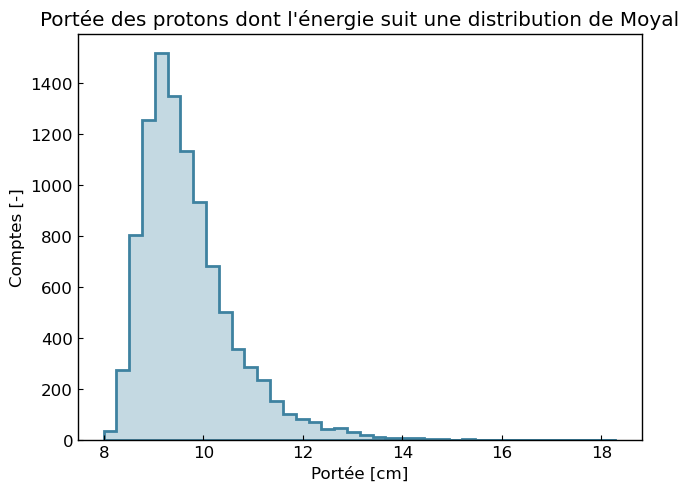

In [43]:
portees = [sp.integrate.quad(f_os, 3, proton)[0] for proton in distribution]

fig = gl.Figure('Portée [cm]', 'Comptes [-]', title="Portée des protons dont l'énergie suit une distribution de Moyal")
fig.add_elements(gl.Histogram(portees, number_of_bins=40, label='', normalize=False))
fig.show(legend=False)

On remarque que la distribution obtenue présente une forme similaire à celle de l'énergie. Conformément au théorème central limite, pour un grand nombre d'échantillons aléatoires, la distribution converge vers la distribution théorique. 

## Énergie déposée

### Il est possible de calculer l’énergie déposée pour un pas de déplacement du proton $s$ dans un milieu comme suit :

$$
\begin{align*}
s = \int_{T_f}^{T_i}\frac{dT'}{S_{col}}
\end{align*}
$$

### où $T_i$ et $T_f$ sont les énergies cinétiques respectivement avant et après que le proton ait subi une perte d’énergie dans l’épaisseur $s$ du matériau.

### 13- Écrivez un algorithme capable de réaliser le transport des protons subissant une décélération continue dans le milieu et tracez le dépôt d’énergie en fonction de la profondeur pour l’eau et l’os pour des protons d’énergie cinétique 150 MeV (faisceau monoénergétique). Votre courbe comportera un point où l’énergie déposée est nulle. La position de ce point est-elle conforme à vos résultats antérieurs sur la portée ? Qu’est-ce qui influence sa valeur ?


10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
10 inf
20 0.00010108587900070631
10 inf
10 inf
20 0.00011605381755153132
10 inf
10 inf
20 0.00013248904533202932
10 inf
10 inf
20 0.00015047137408874534
10 inf
10 inf
20 0.0001700823606700652
10 inf
10 inf
20 0.0001914053755900369
10 inf
20 0.00011127017126977279
10 inf
20 0.00021452567596114136
10 inf
20 0.00012471546571379832
10 inf
20 0.00023953048301095237
10 inf
20 0.00013925748443455177
10 inf
20 0.0002665090646818413
10 inf
20 0.00015494828953688256
10 inf
20 0.0002955528236689986
10 inf
20 0.00017184119912450058
10 inf
20 0.0003267553914021448
10 inf
20 0.00018999084300119762
10 inf
20 0.00036021272849495745
10 inf
20 0.0002094532221450507
10 inf
20 0.0003960232322199886
10 i

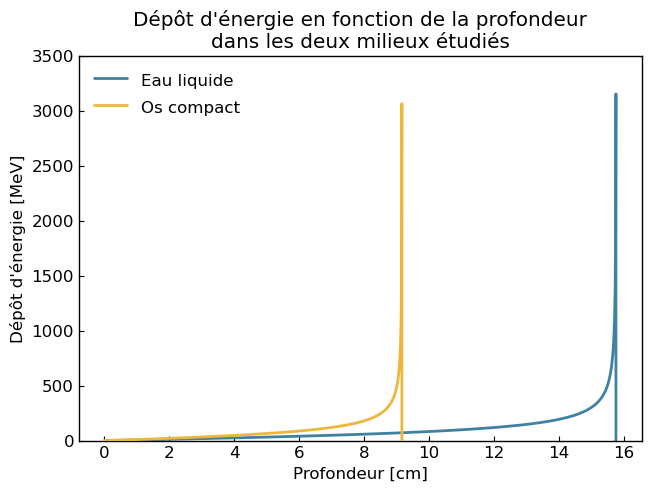

In [ ]:
T = np.linspace(0, 150, 500)
donnees_eau = []
donnees_os = []
T_i = 150
T_f = np.linspace(150, 0.001, 100)
for T_f_i in T_f:
    donnees_eau.append(methode_de_romberg(f_eau, T_f_i, T_i, erreur_max=1e-4)[0])
    donnees_os.append(methode_de_romberg(f_os, T_f_i, T_i, erreur_max=1e-4)[0])

fig = gl.Figure(
    y_label="Dépôt d'énergie [MeV]",
    x_label="Profondeur [cm]",
    y_lim=(0,3500),
    title="Dépôt d'énergie en fonction de la profondeur\ndans les deux milieux étudiés"
)
eau = gl.Curve(donnees_eau, 1/f_eau(T_f), label="Eau liquide")
os = gl.Curve(donnees_os, 1/f_os(T_f), label="Os compact")

fig.add_elements(
    gl.Curve(donnees_eau, donnees_eau/f_eau(T_f), label="Eau liquide"),
    gl.Curve(donnees_os, donnees_os/f_os(T_f), label="Os compact")
)
fig.show()


### 14- On nomme cette courbe le pic de Bragg. En déduire l’intérêt des protons pour la radiothérapie.

La courbe de Bragg représente la perte d'énergie de la radiation ionisante au cours de son parcours à travers la matière. Le pic élevé situé juste avant la portée calculée permet de concentrer le dépôt d'énergie dans une région précise, et donc de limiter les dommages aux tissus environnants. Les protons sont donc utilisés lorsque les traitements de radiothérapie par photons seraient trop dommageables pour les tissus sains.

### 15- Selon vous, est-il nécessaire de calculer les portées jusqu’à la précision machine en protonthérapie ? Pourquoi ?


La précision machine est de l'ordre de $10^{-16}$ fois la portée calculée. Or, la protonthérapie cible des régions constituées d'amas de cellules, dont la taille individuelle est de l'ordre du micromètre. Une précision de l'ordre du micromètre devrait donc être suffisante. Or, pour une portée de l'ordre du mètre, la précision machine est de l'ordre de $10^{-10}$ micromètres, soit plusieurs ordres de grandeur plus précis que nécessaire. Une telle précision ne fait qu'alourdir les calculs pour obtenir une portée précise au noyau nucléaire près, ce qui est loin d'être requis par la procédure.

### 16- En quoi les protons sont-ils préférables aux photons pour traiter un mélanome oculaire ?

Comme mentionné précédemment, le contrôle accru sur la taille de la région irradiée permet de concentrer le traitement sur les cellules cancéreuses et de préserver le tissu oculaire sain aux alentours de la tumeur. Le patient peut donc conserver la vue, au moins en partie, ce qui est extrêmement avantageux.

### 17- Dans l’approche développée ici, les protons vont essentiellement en ligne droite dans la matière. Est-ce réaliste ? Que devra-t-on éventuellement ajouter à notre modèle ?


Les protons sont des particules chargées de masse non nulle. Lors de leur parcours dans la matière, ils entrent en collision avec d'autres particules chargées (électrons, protons) ou non (neutrons). Dans tous les cas, ils subissent des déviations liées aux interactions électromagnétiques et nucléaires. Il n'est donc pas réaliste de considérer un parcours purement linéaire. Il faudrait ajouter au modèle une composante de diffusion dans le milieu qui permettrait, à défaut de calculer la trajectoire exacte de chaque proton, de calculer la distribution angulaire statistique du faisceau de protons.